# Learning Geospatial Analysis with Python
Jupyter notebooks from Joel Lawhead's book'  

## Chapter 1

In [1]:
import turtle as t

In [2]:
NAME = 0
POINTS = 1
POP = 2

In [3]:
state = ["COLORADO", [[-109, 37],[-109, 41],[-102, 41],[-102, 37]], 5187582]
state[1]

[[-109, 37], [-109, 41], [-102, 41], [-102, 37]]

In [4]:
cities = []
cities.append(["DENVER",[-104.98, 39.74], 634265])
cities.append(["BOULDER",[-105.27, 40.02], 98889])
cities.append(["DURANGO",[-107.88,37.28], 17069])

In [5]:
map_width = 400
map_height = 300

In [6]:
minx = 180
maxx = -180
miny = 90
maxy = -90
for x,y in state[POINTS]:
    if x < minx: minx = x
    elif x > maxx: maxx = x
    if y < miny: miny = y
    elif y > maxy: maxy = y

In [7]:
dist_x = maxx - minx
dist_y = maxy - miny
x_ratio = map_width / dist_x
y_ratio = map_height / dist_y

In [8]:
def convert(point):
    lon = point[0]
    lat = point[1]
    x = map_width - ((maxx - lon) * x_ratio)
    y = map_height - ((maxy - lat) * y_ratio)
    # Python turtle graphics start in the
    # middle of the screen
    # so we must offset the points so they are centered
    x = x - (map_width/2)
    y = y - (map_height/2)
    return [x,y]

In [9]:
t.up()
first_pixel = None
for point in state[POINTS]:
    pixel = convert(point)
    if not first_pixel:
        first_pixel = pixel
    t.goto(pixel)
    t.down()
    t.goto(first_pixel)
    t.up()
    t.goto([0,0])
    t.write(state[NAME], align="center", font=("Arial",16,"bold"))
t.done()

This opens a popup window

In [15]:
for city in cities:
    pixel = convert(city[POINTS])
    t.up()
    t.goto(pixel)
    # Place a point for the city
    t.dot(10)
    # Label the city
    t.write(city[NAME] + ", Pop.: " + str(city[POP]), align="left")
    t.up()

biggest_city = max(cities, key=lambda city:city[POP])
t.goto(0,-200)
t.write("The biggest city is: " + biggest_city[NAME])

western_city = min(cities, key=lambda city:city[POINTS])
t.goto(0,-220)
t.write("The western-most city is: " + western_city[NAME])
t.done()

### Plotting a shapefile with GDAL/OGR and Matplotlib
An algorithm from [GeogG122](http://www2.geog.ucl.ac.uk/~plewis/geogg122_current/_build/html/Chapter4_GDAL/OGR_Python.html) that uses Matplotlib to plot a shapefile. 

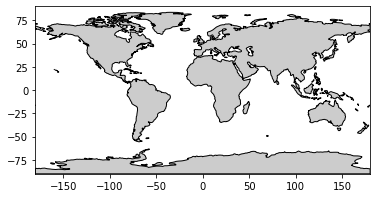

In [17]:
from osgeo import ogr, osr
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Extract first layer of features from shapefile using OGR
ds = ogr.Open('data/vector/global/ne_110m_land_1p.shp')
lyr = ds.GetLayer(0)


# Prepare figure
plt.ioff()
plt.subplot(1,1,1)
ax = plt.gca()


paths = []
lyr.ResetReading()

#lyr.SetAttributeFilter ( " NAME = 'ANGOLA' ")
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
# Read all features in layer and store as paths

for feat in lyr:

    for geom in feat.GetGeometryRef():
        envelope = np.array( geom.GetEnvelope() )
        # check if geom is polygon
        if geom.GetGeometryType() == ogr.wkbPolygon:
            codes = []
            all_x = []
            all_y = []
            for i in range(geom.GetGeometryCount()):
                # Read ring geometry and create path
                r = geom.GetGeometryRef(i)
                x = [r.GetX(j) for j in range(r.GetPointCount())]
                y = [r.GetY(j) for j in range(r.GetPointCount())]
                # skip boundary between individual rings
                codes += [mpath.Path.MOVETO] + \
                             (len(x)-1)*[mpath.Path.LINETO]
                all_x += x
                all_y += y
            path = mpath.Path(np.column_stack((all_x,all_y)), codes)
            paths.append(path)
    # Add paths as patches to axes
    for path in paths:
        patch = mpatches.PathPatch(path, \
                facecolor='0.8', edgecolor='black')
        ax.add_patch(patch)

ax.set_aspect(1.0)
plt.show()